# Load Data Into SQL Database

Load the datasets (stores in .csv files) into SQL Database called eda_project.

In [1]:
import sqlite3
import sqlalchemy 
from sqlalchemy import create_engine
from datetime import datetime, timedelta,date
import pandas as pd
import csv
import warnings

Take last 5 months data from the MTA turstile dataset (Feb 2021 to July 2021) and load it in .CSV file

In [2]:

#function to generate data from augest 2020 to august 2021
def generate_weeks(starting_date):
    weeks=[]
    x=datetime.strptime(starting_date, '%d-%m-%Y')
    date_time_str = '2021-07-01'
    date_time_obj =datetime.strptime(date_time_str, '%Y-%m-%d')
    end_date = datetime(date_time_obj.year, date_time_obj.month, date_time_obj.day)
    while x<end_date:
        strr=x.strftime("%x")
        strr= strr[6:]+strr[0:2]+strr[3:5]
        weeks.append(strr)
        x = x + timedelta(days=7)

    return weeks
weeks_list= generate_weeks('02-01-2021')

In [3]:
#function to extract data from MTA turnstile dataset and save it .CSV file

import requests
def load_data(weeks):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in weeks:
        url_file = url.format(week_num)
        req = requests.get(url_file)
        url_content = req.content
        csv_file = open('turnstile.csv', "ab")
        csv_file.write(url_content)
    csv_file.close()
load_data(weeks_list)

Obtain the equipment(aka elevators,escalators,turstiles) data from MTA API

In [4]:
import csv
api_key='qmnIE64nrW7T0MQ09kf0A18VUw2EnigW561U3DLS'

def get_json_into_csv(url, c_file_name):
    header = { "x-api-key": api_key}
    a = requests.get(url, headers=header)
    a= a.json()
    data_file = open(c_file_name, "a",newline='')
    csv_writer = csv.writer(data_file)
 
    count = 0
    for data in a:
        if count == 0:
            header = data.keys()
            csv_writer.writerow(header)
            count += 1
        csv_writer.writerow(data.values())
 
    data_file.close()

In [ ]:
get_json_into_csv("https://api-endpoint.mta.info/Dataservice/mtagtfsfeeds/nyct%2Fnyct_ene_equipments.json",'Equipment.csv')

In [6]:
get_json_into_csv("https://api-endpoint.mta.info/Dataservice/mtagtfsfeeds/nyct%2Fnyct_ene.json",'e_outages.csv')

In [7]:
get_json_into_csv("https://api-endpoint.mta.info/Dataservice/mtagtfsfeeds/nyct%2Fnyct_ene_upcoming.json",'upcoming_outages.csv')

### Load .CSV files into SQL Database

In [58]:

data=[]
warnings.filterwarnings('ignore')
connection = sqlite3.connect('eda_project.db')
cursor = connection.cursor()
def load_into_db(t, insert_statement):
    #connection.open()
    with open(t, 'r', encoding='latin1') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)
        data = list()
        for row in reader:
            data.append(row)
    cursor.executemany(insert_statement, data)
    connection.commit()
    connection.close()

1- MTA Turnstile Data

In [8]:
insert_turnstile = r"INSERT INTO turnstile VALUES(?,?,?,?,?,?,?,?,?,?,?)"
load_into_db('turnstile.csv',insert_turnstile)

2- MTA Elevator Data

In [59]:
insert_elv = r"INSERT INTO elevator VALUES(?,?,?,?,?,?,?,?,?,?,?)"
load_into_db('EE_master_list.csv',insert_elv)

# EDA

Working with pandas

In [12]:
engine = create_engine("sqlite:///eda_project.db")


In [13]:
all_tables = engine.table_names()
all_tables

['elevator', 'nyc_weather', 'turnstile']

# MTA Data Exploration

In [14]:
turnstile_data= pd.read_sql('SELECT * FROM turnstile;', engine)
turnstile_data

,C/A\t,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,03:00:00,REGULAR,7508509,2557569
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,07:00:00,REGULAR,7508511,2557581
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,11:00:00,REGULAR,7508531,2557636
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,15:00:00,REGULAR,7508610,2557667
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,19:00:00,REGULAR,7508767,2557689
...,...,...,...,...,...,...,...,...,...,...,...
6070879,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/25/2021,05:00:00,REGULAR,5554,584
6070880,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/25/2021,09:00:00,REGULAR,5554,584
6070881,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/25/2021,13:00:00,REGULAR,5554,584
6070882,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/25/2021,17:00:00,REGULAR,5554,584


In [15]:
turnstile_data = turnstile_data.rename(columns={'C/A\t': 'C/A'})

In [16]:
turnstile_data['turnstile'] = turnstile_data['C/A'] + '-' + turnstile_data['UNIT'] + '-' + turnstile_data['SCP'] + '-' + turnstile_data['STATION'] 

In [17]:
# Checking columns names

turnstile_data.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS', 'turnstile'],
      dtype='object')

In [18]:
# Eliminate spaces at columns names

turnstile_data.columns = turnstile_data.columns.str.strip()
turnstile_data.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS', 'turnstile'],
      dtype='object')

In [19]:
#explore the data types
turnstile_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6070884 entries, 0 to 6070883
Data columns (total 12 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   C/A        object
 1   UNIT       object
 2   SCP        object
 3   STATION    object
 4   LINENAME   object
 5   DIVISION   object
 6   DATE       object
 7   TIME       object
 8   DESC       object
 9   ENTRIES    object
 10  EXITS      object
 11  turnstile  object
dtypes: object(12)
memory usage: 555.8+ MB


In [20]:
turnstile_data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,turnstile
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,03:00:00,REGULAR,7508509,2557569,A002-R051-02-00-00-59 ST
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,07:00:00,REGULAR,7508511,2557581,A002-R051-02-00-00-59 ST
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,11:00:00,REGULAR,7508531,2557636,A002-R051-02-00-00-59 ST
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,15:00:00,REGULAR,7508610,2557667,A002-R051-02-00-00-59 ST
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,19:00:00,REGULAR,7508767,2557689,A002-R051-02-00-00-59 ST


In [21]:
turnstile_data = turnstile_data[turnstile_data.DATE != 'DATE']

In [22]:
turnstile_data.shape

(6070856, 12)

In [23]:
turnstile_data['DATETIME'] = pd.to_datetime(turnstile_data.DATE + ' ' + turnstile_data.TIME, format='%m/%d/%Y  %H:%M:%S')

turnstile_data['DATE']=pd.to_datetime(turnstile_data.DATE,format='%m/%d/%Y')
turnstile_data['TIME'] = pd.to_datetime(turnstile_data.TIME, format='%H:%M:%S').dt.time

In [24]:
turnstile_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6070856 entries, 0 to 6070883
Data columns (total 13 columns):
 #   Column     Dtype         
---  ------     -----         
 0   C/A        object        
 1   UNIT       object        
 2   SCP        object        
 3   STATION    object        
 4   LINENAME   object        
 5   DIVISION   object        
 6   DATE       datetime64[ns]
 7   TIME       object        
 8   DESC       object        
 9   ENTRIES    object        
 10  EXITS      object        
 11  turnstile  object        
 12  DATETIME   datetime64[ns]
dtypes: datetime64[ns](2), object(11)
memory usage: 648.4+ MB


In [25]:
#Create a column that called "NAMEOFDAY"
turnstile_data["NAMEOFDAY"]= turnstile_data["DATETIME"].dt.day_name()

#Checking sample 5 rows
turnstile_data.sample(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,turnstile,DATETIME,NAMEOFDAY
6030471,R253,R181,00-00-02,110 ST,6,IRT,2021-06-20,16:00:00,REGULAR,5809552,13726620,R253-R181-00-00-02-110 ST,2021-06-20 16:00:00,Sunday
3940272,R262B,R195,05-00-01,161/YANKEE STAD,4BD,IRT,2021-04-14,04:22:00,REGULAR,601005,79065,R262B-R195-05-00-01-161/YANKEE STAD,2021-04-14 04:22:00,Wednesday
2365484,N086,R282,00-00-00,SPRING ST,CE,IND,2021-02-21,15:00:00,REGULAR,6646660,1698373,N086-R282-00-00-00-SPRING ST,2021-02-21 15:00:00,Sunday
2357144,N046,R281,00-06-00,72 ST,BC,IND,2021-02-23,23:00:00,REGULAR,666270,909120,N046-R281-00-06-00-72 ST,2021-02-23 23:00:00,Tuesday
1312939,N051,R084,02-00-04,59 ST COLUMBUS,ABCD1,IND,2021-01-19,15:00:00,REGULAR,1398378329,1087089175,N051-R084-02-00-04-59 ST COLUMBUS,2021-01-19 15:00:00,Tuesday


### MTA Turnstile Data Cleaning

Checking null values based on columns


In [26]:
turnstile_data.isnull().sum()

C/A          0
UNIT         0
SCP          0
STATION      0
LINENAME     0
DIVISION     0
DATE         0
TIME         0
DESC         0
ENTRIES      0
EXITS        0
turnstile    0
DATETIME     0
NAMEOFDAY    0
dtype: int64

clean duplicate Entries

In [27]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
x= (turnstile_data
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATETIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False))
x.head(50)

,C/A,UNIT,SCP,STATION,DATETIME,ENTRIES
3770848,R162,R166,00-00-00,79 ST,2020-12-30 00:00:00,4
3770850,R162,R166,00-00-00,79 ST,2020-12-30 08:00:00,4
3771924,R162,R166,00-00-01,79 ST,2020-12-31 08:00:00,4
490459,B028,R136,01-00-01,SHEEPSHEAD BAY,2021-01-08 04:00:00,4
3770852,R162,R166,00-00-00,79 ST,2020-12-30 16:00:00,4
3770853,R162,R166,00-00-00,79 ST,2020-12-30 20:00:00,4
3770854,R162,R166,00-00-00,79 ST,2020-12-31 00:00:00,4
3771922,R162,R166,00-00-01,79 ST,2020-12-31 00:00:00,4
3770856,R162,R166,00-00-00,79 ST,2020-12-31 08:00:00,4
3771921,R162,R166,00-00-01,79 ST,2020-12-30 20:00:00,4


after observing some data are duplicated 4 time , it's time to drop them 

In [28]:
turnstile_data= turnstile_data.drop_duplicates()

In [29]:
turnstile_data.shape

(5440376, 14)

make sure that EXITIS is less than ENTRIES because the emergency exits in the station doesn't have turnstile

In [30]:
print('Descriptions of entries:')
print(turnstile_data['ENTRIES'].describe())
print('')
print('Descriptions of exits:')
print(turnstile_data['EXITS'].describe())

Descriptions of entries:
count     5440376
unique    3169786
top             0
freq        75942
Name: ENTRIES, dtype: int64

Descriptions of exits:
count     5440376
unique    2941521
top             0
freq       218566
Name: EXITS, dtype: int64


Working with only neccessary columns

In [31]:
turnstile_data = turnstile_data[["STATION",'turnstile',"DATE","TIME","DATETIME","NAMEOFDAY","ENTRIES","EXITS"]]

deal with counter working in reverse

In [32]:
turnstile_data.sort_values(['turnstile','DATETIME'],inplace=True)

In [33]:
turnstiles_daily1 = (turnstile_data
                        .groupby(['turnstile', "STATION", "DATE","NAMEOFDAY"],as_index=False)
                        .ENTRIES.last())
turnstiles_daily2 = (turnstile_data
                        .groupby(['turnstile', "STATION", "DATE","NAMEOFDAY"],as_index=False)
                        .EXITS.last())
turnstiles_daily= pd.merge(turnstiles_daily1,turnstiles_daily2, on=['turnstile', "STATION", "DATE","NAMEOFDAY"] )

In [34]:
turnstiles_daily.head()

,turnstile,STATION,DATE,NAMEOFDAY,ENTRIES,EXITS
0,A002-R051-02-00-00-59 ST,59 ST,2020-12-26,Saturday,7508852,2557704
1,A002-R051-02-00-00-59 ST,59 ST,2020-12-27,Sunday,7509162,2557824
2,A002-R051-02-00-00-59 ST,59 ST,2020-12-28,Monday,7509820,2558109
3,A002-R051-02-00-00-59 ST,59 ST,2020-12-29,Tuesday,7510454,2558348
4,A002-R051-02-00-00-59 ST,59 ST,2020-12-30,Wednesday,7511062,2558590


In [35]:
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES","PREV_EXITS"]] = (turnstiles_daily
                                                       .groupby(["turnstile", "STATION"])["DATE", "ENTRIES","EXITS"]
                                                       .apply(lambda grp: grp.shift(1)))

In [36]:
turnstiles_daily.head()

,turnstile,STATION,DATE,NAMEOFDAY,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
0,A002-R051-02-00-00-59 ST,59 ST,2020-12-26,Saturday,7508852,2557704,NaT,NaN,NaN
1,A002-R051-02-00-00-59 ST,59 ST,2020-12-27,Sunday,7509162,2557824,2020-12-26,7508852.0,2557704.0
2,A002-R051-02-00-00-59 ST,59 ST,2020-12-28,Monday,7509820,2558109,2020-12-27,7509162.0,2557824.0
3,A002-R051-02-00-00-59 ST,59 ST,2020-12-29,Tuesday,7510454,2558348,2020-12-28,7509820.0,2558109.0
4,A002-R051-02-00-00-59 ST,59 ST,2020-12-30,Wednesday,7511062,2558590,2020-12-29,7510454.0,2558348.0


In [37]:
# Drop the rows for the earliest date in the df
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [38]:
turnstiles_daily[(turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]) ].head()

,turnstile,STATION,DATE,NAMEOFDAY,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
814,A002-R051-02-03-02-59 ST,59 ST,2021-03-22,Monday,238,88,2021-03-21,6641395.0,8869456.0
7096,A011-R080-01-03-00-57 ST-7 AV,57 ST-7 AV,2020-12-27,Sunday,885630496,489703109,2020-12-26,885630596.0,489703569.0
7097,A011-R080-01-03-00-57 ST-7 AV,57 ST-7 AV,2020-12-28,Monday,885630280,489702305,2020-12-27,885630496.0,489703109.0
7098,A011-R080-01-03-00-57 ST-7 AV,57 ST-7 AV,2020-12-29,Tuesday,885630041,489701473,2020-12-28,885630280.0,489702305.0
7099,A011-R080-01-03-00-57 ST-7 AV,57 ST-7 AV,2020-12-30,Wednesday,885629851,489700579,2020-12-29,885630041.0,489701473.0


In [39]:
turnstiles_daily[(turnstiles_daily["EXITS"] < turnstiles_daily["PREV_EXITS"]) ].head()

,turnstile,STATION,DATE,NAMEOFDAY,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
814,A002-R051-02-03-02-59 ST,59 ST,2021-03-22,Monday,238,88,2021-03-21,6641395.0,8869456.0
3863,A007-R079-01-05-01-5 AV/59 ST,5 AV/59 ST,2021-02-08,Monday,262144,7,2021-02-06,0.0,26.0
7096,A011-R080-01-03-00-57 ST-7 AV,57 ST-7 AV,2020-12-27,Sunday,885630496,489703109,2020-12-26,885630596.0,489703569.0
7097,A011-R080-01-03-00-57 ST-7 AV,57 ST-7 AV,2020-12-28,Monday,885630280,489702305,2020-12-27,885630496.0,489703109.0
7098,A011-R080-01-03-00-57 ST-7 AV,57 ST-7 AV,2020-12-29,Tuesday,885630041,489701473,2020-12-28,885630280.0,489702305.0


In [40]:
def get_daily_counts(row, max_counter, col):
    pre= "PREV_"+col
    counter = row[col] - row[pre]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        counter = min(row[col], row[pre])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000, col='ENTRIES')
turnstiles_daily["DAILY_EXITS"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000, col='EXITS')

In [41]:
turnstiles_daily.head()

,turnstile,STATION,DATE,NAMEOFDAY,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS
1,A002-R051-02-00-00-59 ST,59 ST,2020-12-27,Sunday,7509162,2557824,2020-12-26,7508852.0,2557704.0,310.0,120.0
2,A002-R051-02-00-00-59 ST,59 ST,2020-12-28,Monday,7509820,2558109,2020-12-27,7509162.0,2557824.0,658.0,285.0
3,A002-R051-02-00-00-59 ST,59 ST,2020-12-29,Tuesday,7510454,2558348,2020-12-28,7509820.0,2558109.0,634.0,239.0
4,A002-R051-02-00-00-59 ST,59 ST,2020-12-30,Wednesday,7511062,2558590,2020-12-29,7510454.0,2558348.0,608.0,242.0
5,A002-R051-02-00-00-59 ST,59 ST,2020-12-31,Thursday,7511447,2558784,2020-12-30,7511062.0,2558590.0,385.0,194.0


Find the daily traffic of each turnstile, because we are intrested in the maintaince of crowded stations. we take both entries and exits

In [42]:
#Finding Daily traffic(entries+exits) based on turnstile

turnstiles_daily.drop('ENTRIES', inplace=True, axis=1)
turnstiles_daily.drop('EXITS', inplace=True, axis=1)
turnstiles_daily.drop('PREV_DATE', inplace=True, axis=1)
turnstiles_daily.drop('PREV_ENTRIES', inplace=True, axis=1)
turnstiles_daily.drop('PREV_EXITS', inplace=True, axis=1)

turnstiles_daily["TRAFFIC"] = turnstiles_daily["DAILY_ENTRIES"] + turnstiles_daily["DAILY_EXITS"]

turnstiles_daily

,turnstile,STATION,DATE,NAMEOFDAY,DAILY_ENTRIES,DAILY_EXITS,TRAFFIC
1,A002-R051-02-00-00-59 ST,59 ST,2020-12-27,Sunday,310.0,120.0,430.0
2,A002-R051-02-00-00-59 ST,59 ST,2020-12-28,Monday,658.0,285.0,943.0
3,A002-R051-02-00-00-59 ST,59 ST,2020-12-29,Tuesday,634.0,239.0,873.0
4,A002-R051-02-00-00-59 ST,59 ST,2020-12-30,Wednesday,608.0,242.0,850.0
5,A002-R051-02-00-00-59 ST,59 ST,2020-12-31,Thursday,385.0,194.0,579.0
...,...,...,...,...,...,...,...
908232,TRAM2-R469-00-05-01-RIT-ROOSEVELT,RIT-ROOSEVELT,2021-06-21,Monday,0.0,0.0,0.0
908233,TRAM2-R469-00-05-01-RIT-ROOSEVELT,RIT-ROOSEVELT,2021-06-22,Tuesday,0.0,0.0,0.0
908234,TRAM2-R469-00-05-01-RIT-ROOSEVELT,RIT-ROOSEVELT,2021-06-23,Wednesday,0.0,0.0,0.0
908235,TRAM2-R469-00-05-01-RIT-ROOSEVELT,RIT-ROOSEVELT,2021-06-24,Thursday,0.0,0.0,0.0


**Get the top 10 busiest stations**

In [43]:
#Checking Unique Station count

len(turnstile_data["STATION"].unique())

379

In [44]:
traffic_per_station = turnstiles_daily.groupby('STATION')[['TRAFFIC']].agg('sum')
#sort by the traffic value
traffic_per_station= traffic_per_station.sort_values(by=['TRAFFIC'], ascending=False)
traffic_per_station.head(10)

,TRAFFIC
STATION,
34 ST-PENN STA,14683671.0
34 ST-HERALD SQ,14028968.0
TIMES SQ-42 ST,13246982.0
86 ST,12048526.0
125 ST,10996093.0
PATH NEW WTC,10692222.0
GRD CNTRL-42 ST,10615042.0
23 ST,9837871.0
42 ST-PORT AUTH,9155759.0


Get top 10 busisest station

In [45]:
top_10_stations=traffic_per_station.head(10)
top_10_stations=top_10_stations.reset_index()

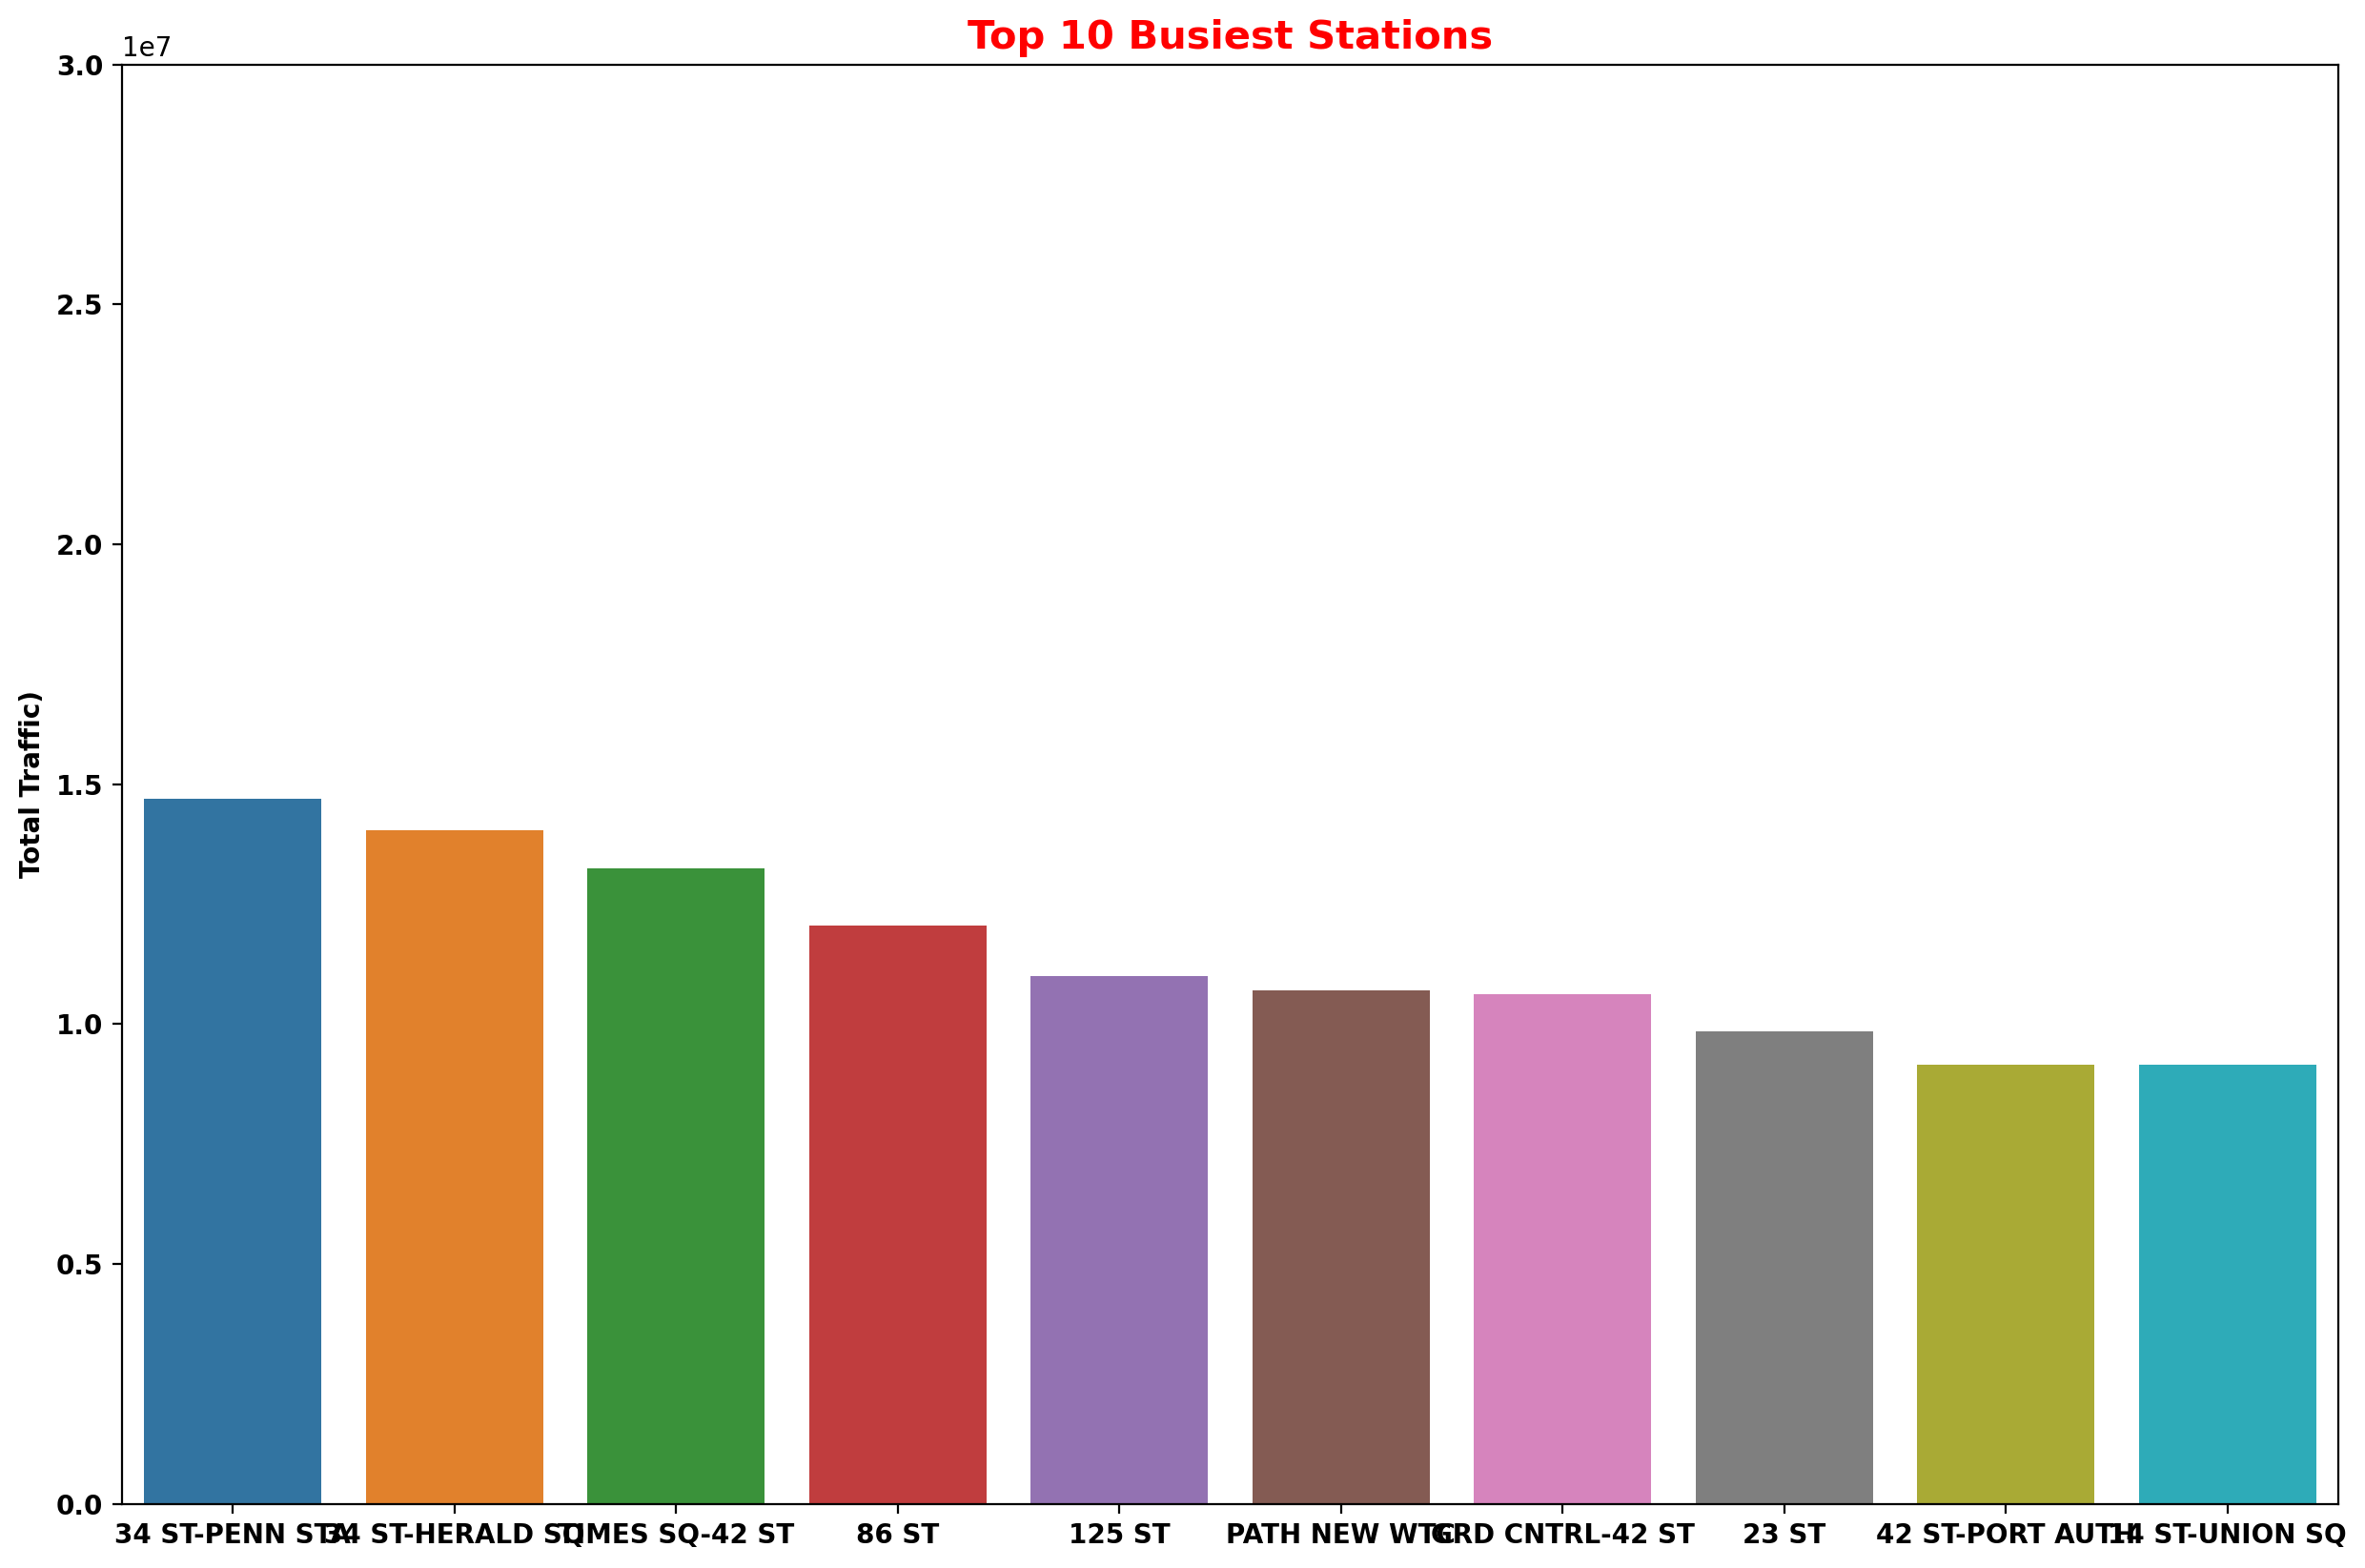

In [46]:
#Barplot for Top 10 Busiest Stations
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,10),dpi=200),
plt.style.use('default')
ax = sns.barplot(y="TRAFFIC", x="STATION", data=top_10_stations)
plt.title("Top 10 Busiest Stations", weight="bold", c="red", fontsize=15)
plt.xlabel("",weight="bold",c="k")
plt.xticks(rotation=0, weight="bold")
plt.ylabel("Total Traffic)",weight= "bold",c="k")
plt.ylim(0,30000000)
plt.yticks(weight="bold")
plt.savefig('images/01_Top10BusiesStationsBarPlot.png', dpi=200)
plt.show()

**Get Trafic based on Days Of Week**

In [47]:

# Finding overall busiest day based on traffic
mta_busiest_day = turnstiles_daily.groupby("NAMEOFDAY")[['TRAFFIC']].agg('sum')

mta_busiest_day = mta_busiest_day.sort_values(by=['TRAFFIC'], ascending=False).reset_index()
mta_busiest_day

,NAMEOFDAY,TRAFFIC
0,Friday,114200925.0
1,Thursday,112877659.0
2,Wednesday,108816363.0
3,Tuesday,107196258.0
4,Monday,96259300.0
5,Saturday,78375829.0
6,Sunday,63982299.0


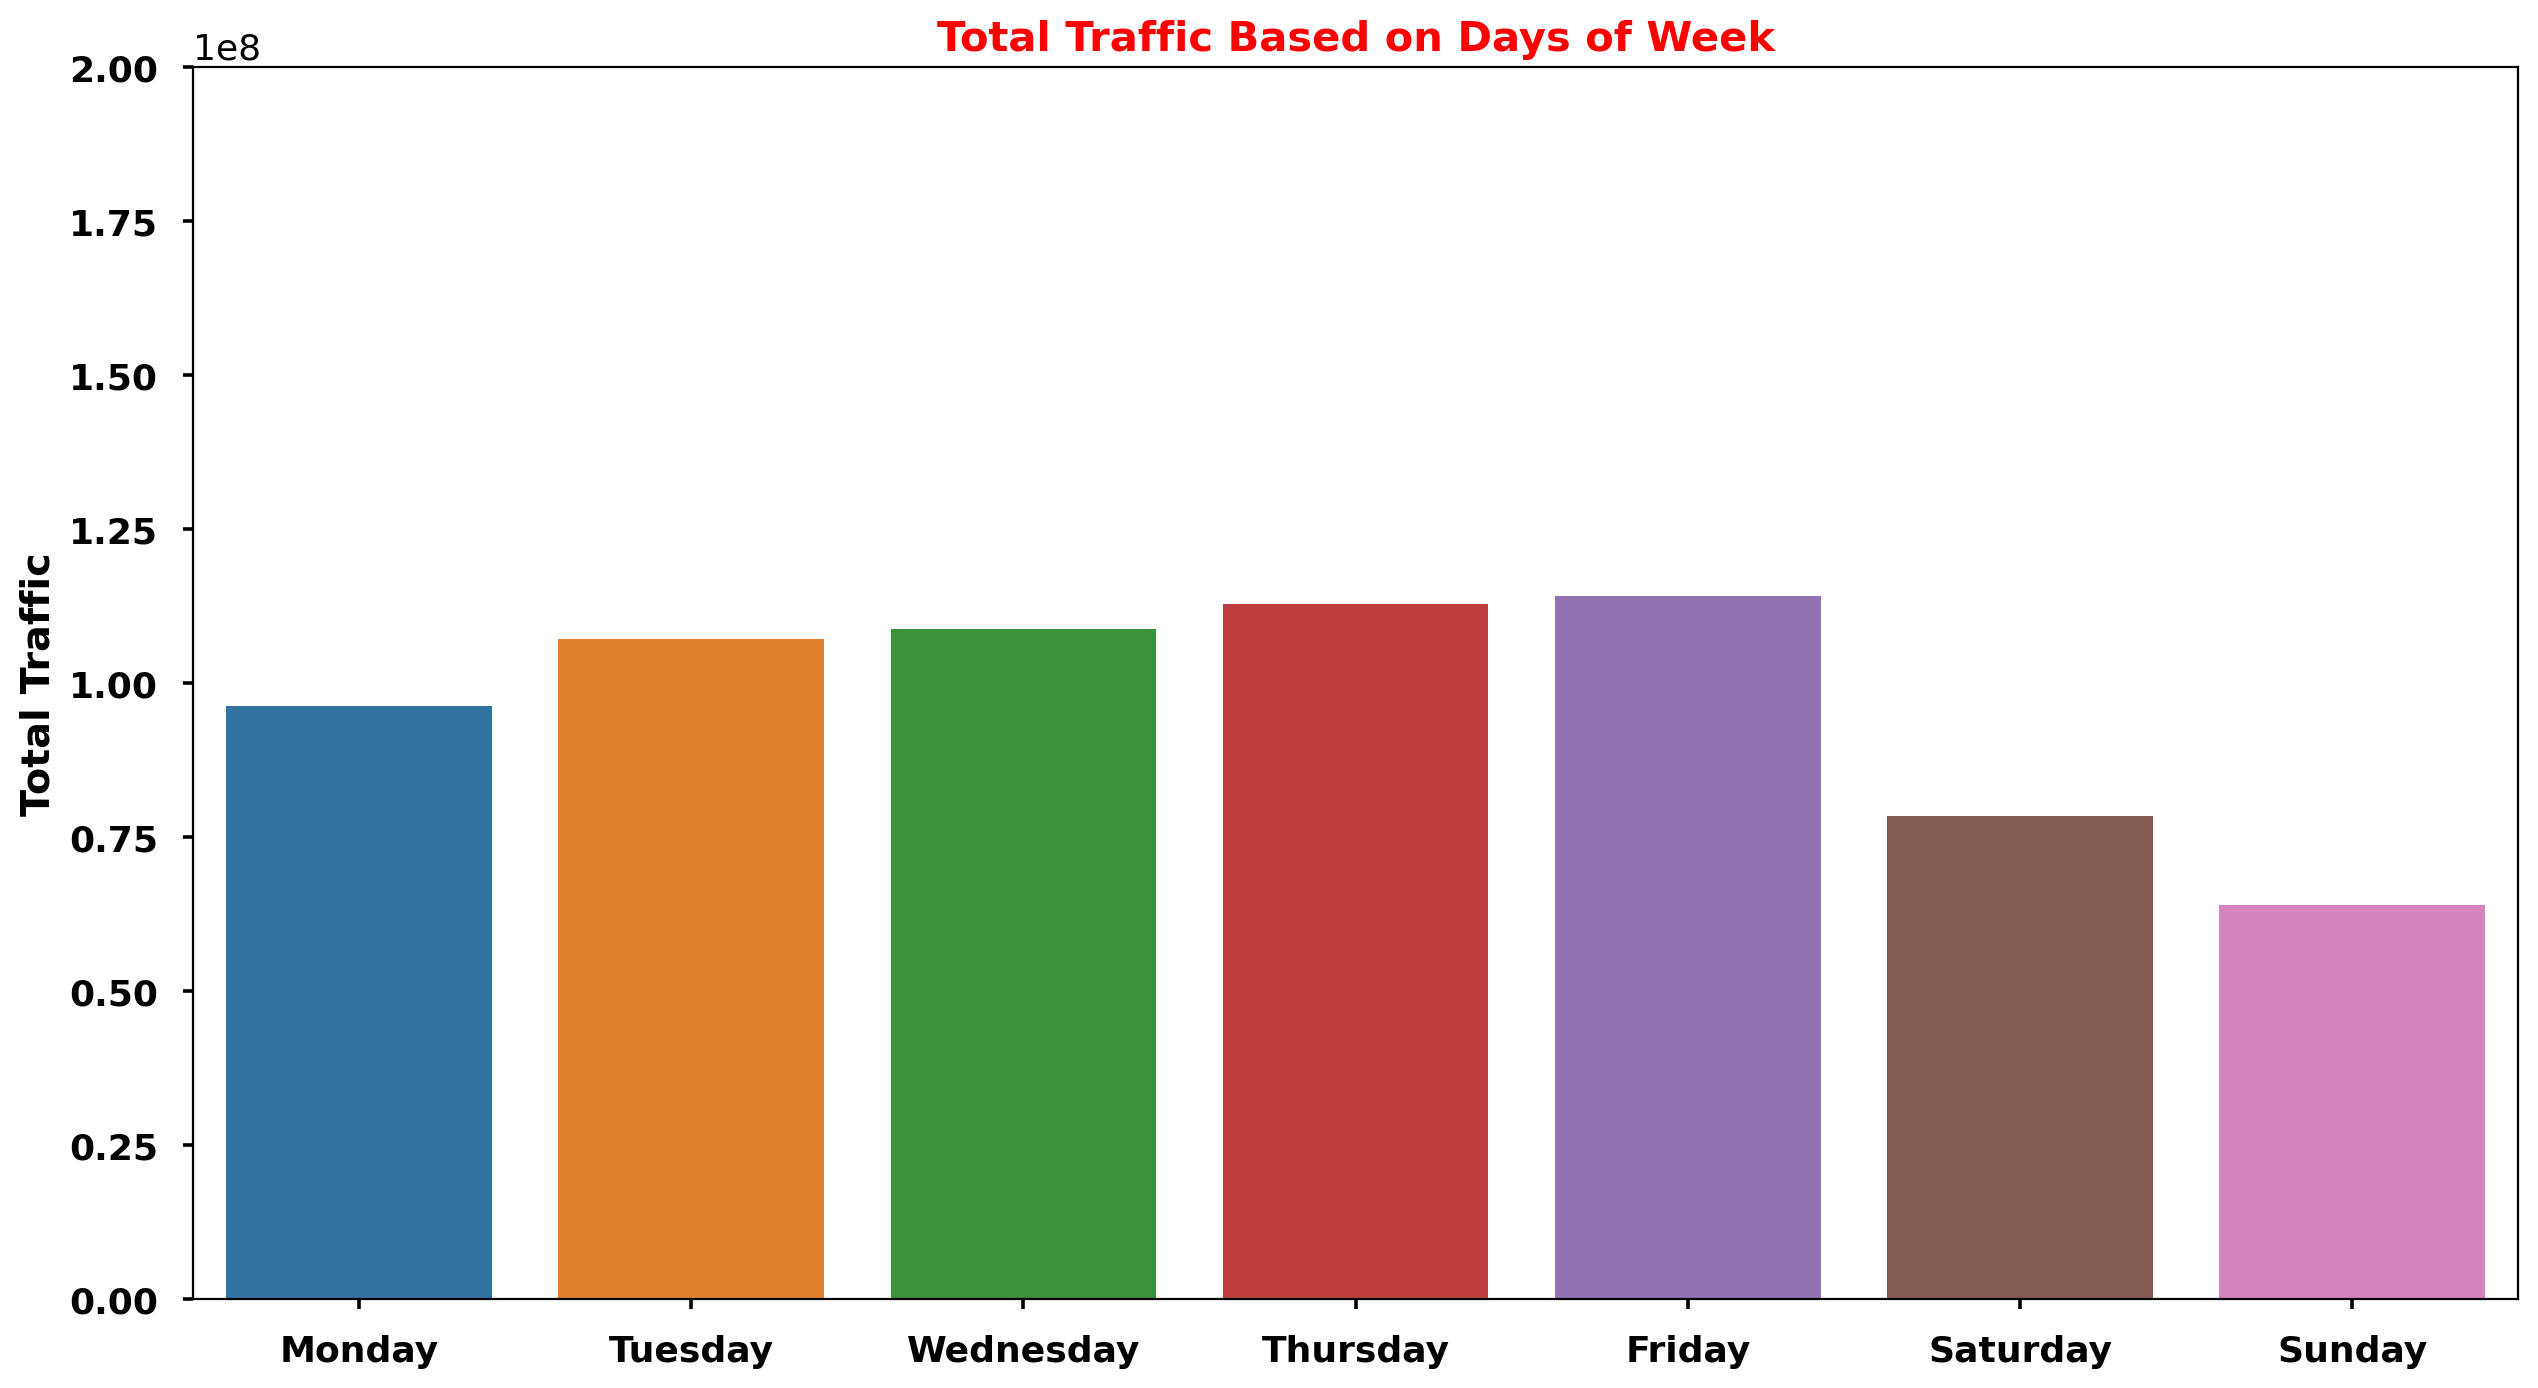

In [48]:
#Barplot for total traffic
plt.figure(figsize=(15,8),dpi=200),
plt.style.use('seaborn-talk')

ax = sns.barplot(x="NAMEOFDAY",y="TRAFFIC",data=mta_busiest_day, order=["Monday","Tuesday","Wednesday","Thursday",
                                                                       "Friday","Saturday","Sunday"])

plt.title("Total Traffic Based on Days of Week", weight="bold", c="red",fontsize=15)
plt.xlabel("")
plt.ylabel("Total Traffic",weight= "bold")
plt.yticks(weight="bold")
plt.xticks(weight="bold")
plt.ylim(0,200000000)
plt.savefig('images/02_TotalTrafficPerDayBarPlot2.png', dpi=200)
plt.show()

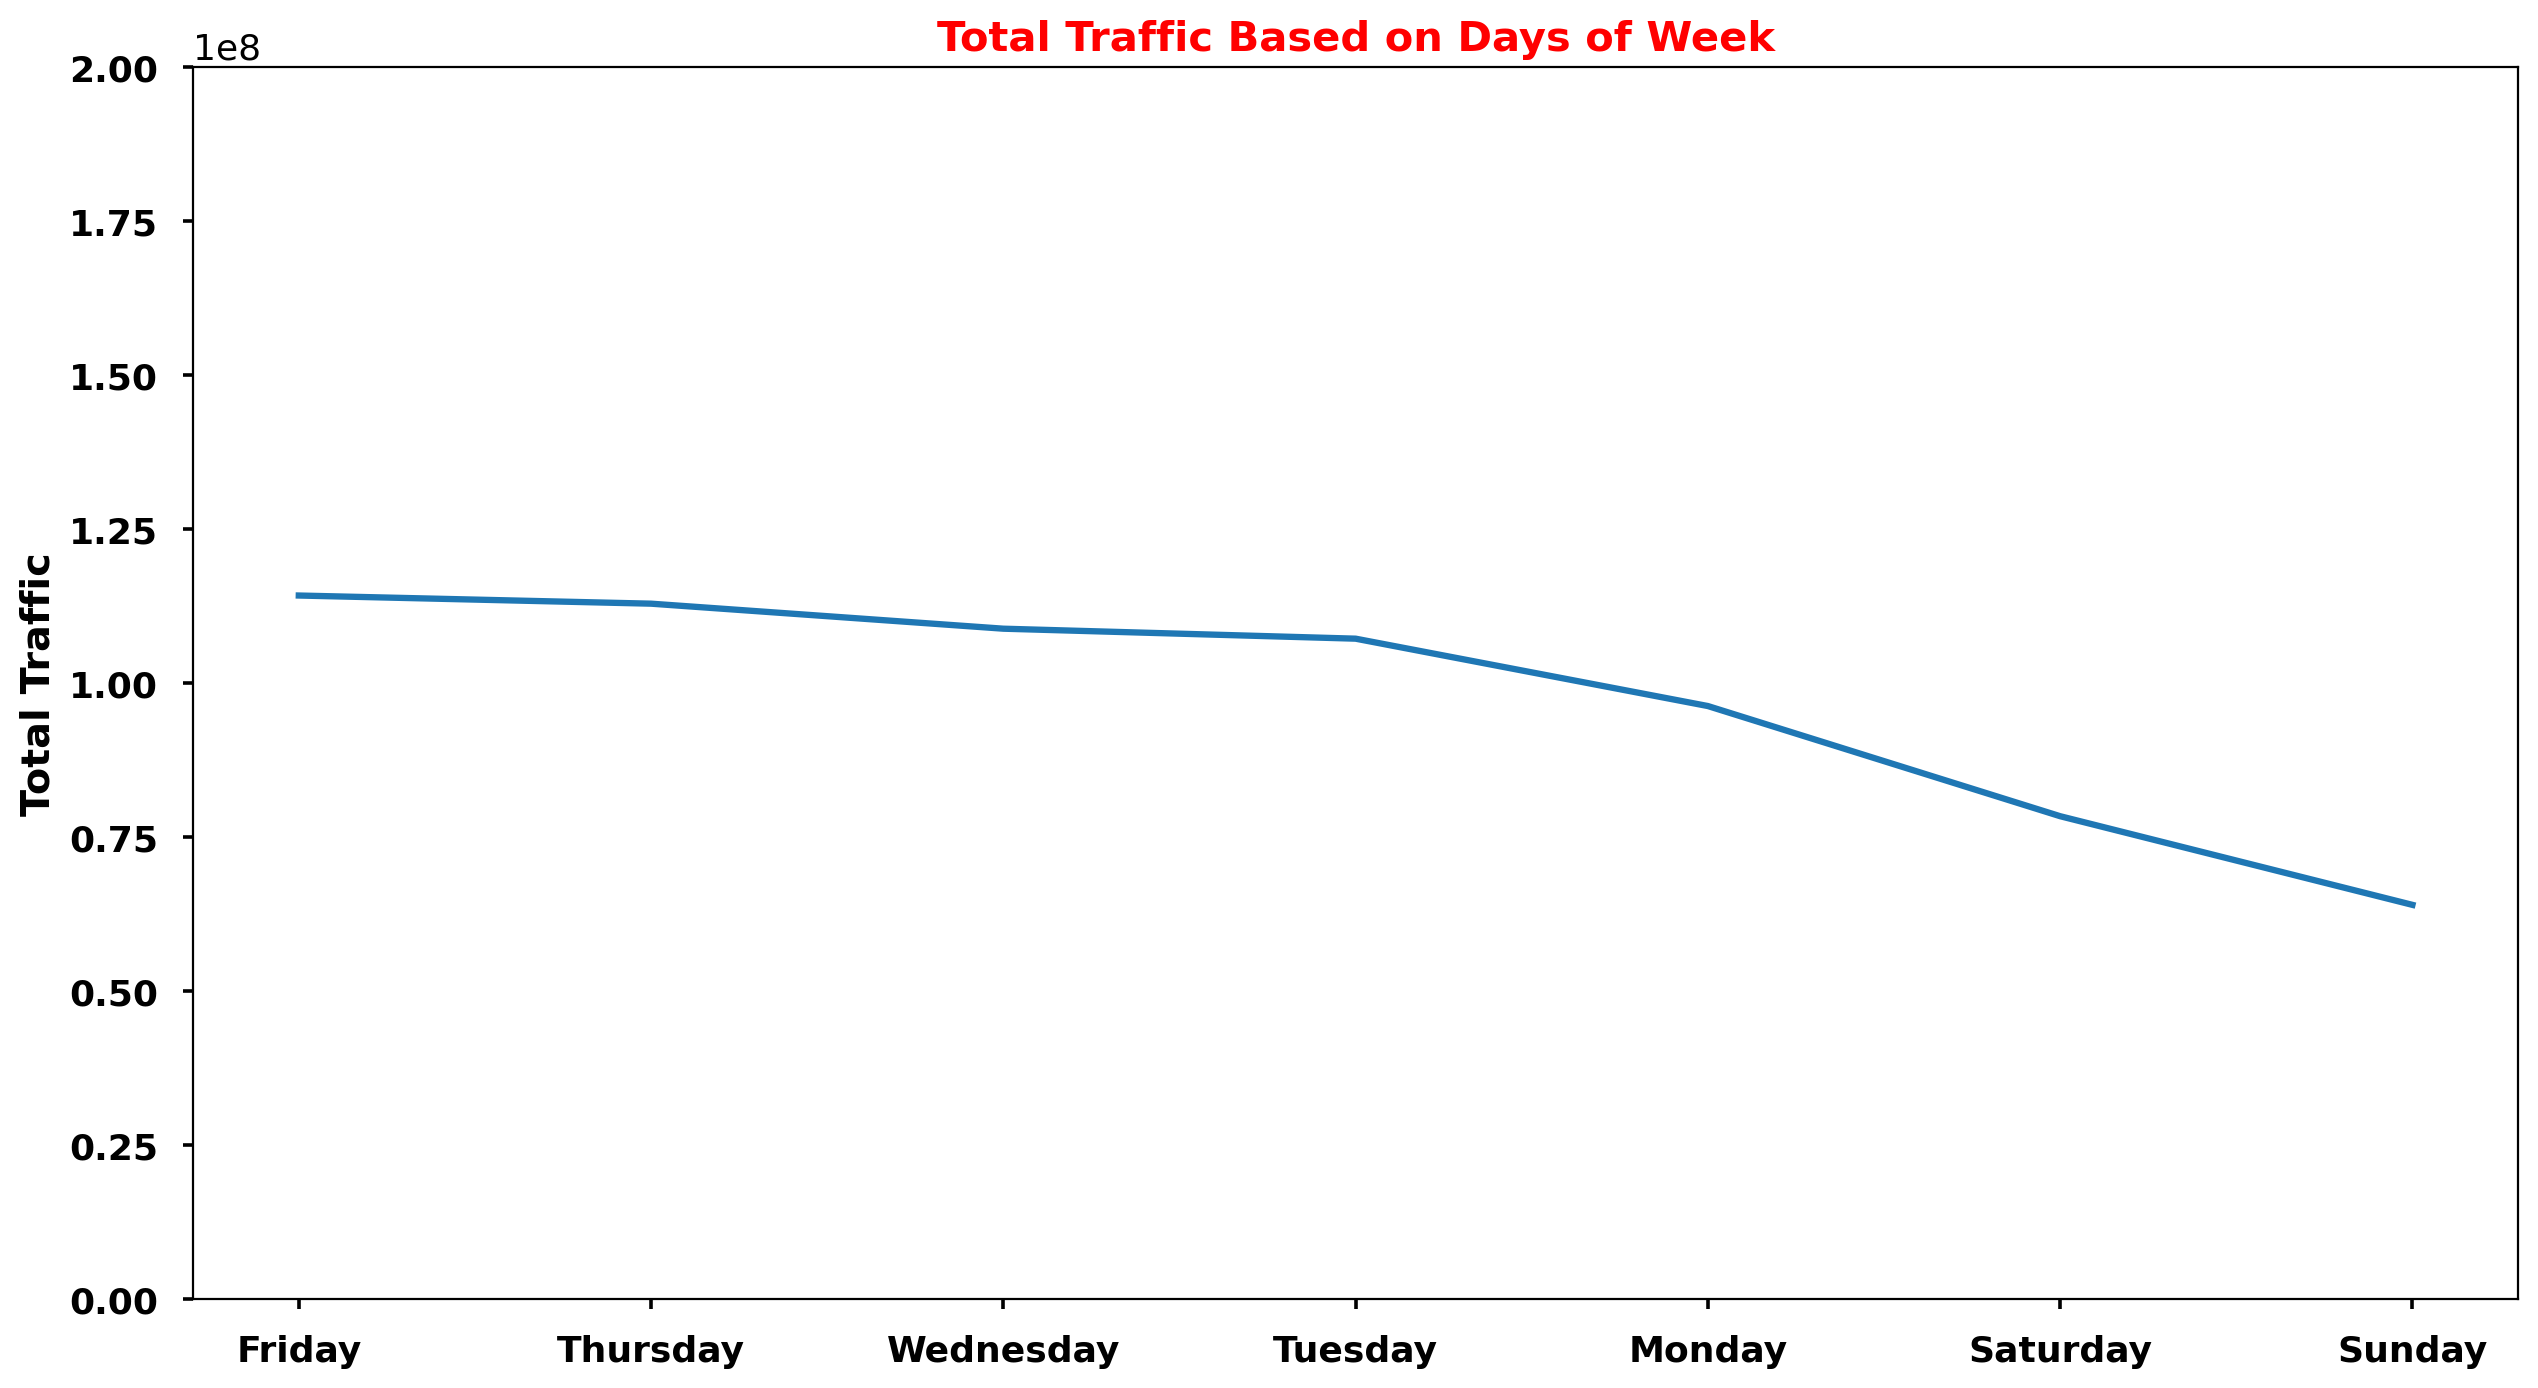

In [49]:
plt.figure(figsize=(15,8),dpi=200),
plt.style.use('seaborn-talk')

ax = sns.lineplot(x="NAMEOFDAY",y="TRAFFIC",data=mta_busiest_day)

plt.title("Total Traffic Based on Days of Week", weight="bold", c="red",fontsize=15)
plt.xlabel("")
plt.ylabel("Total Traffic",weight= "bold")
plt.yticks(weight="bold")
plt.xticks(weight="bold")
plt.ylim(0,200000000)
plt.savefig('images/02_TotalTrafficPerDayBarPlot.png', dpi=200)
plt.show()

**Plot Top 10 Busiest Stations per Day**

In [50]:
top10_station_list = top_10_stations["STATION"]
top10_station_list

0     34 ST-PENN STA
1    34 ST-HERALD SQ
2     TIMES SQ-42 ST
3              86 ST
4             125 ST
5       PATH NEW WTC
6    GRD CNTRL-42 ST
7              23 ST
8    42 ST-PORT AUTH
9     14 ST-UNION SQ
Name: STATION, dtype: object

In [51]:
#Daily Usage for Top 10 Stations
mta_top10_daily = turnstiles_daily.groupby(["STATION","NAMEOFDAY"]).sum()

mta_top10_daily = mta_top10_daily.reset_index()

mta_top10_daily = mta_top10_daily[(mta_top10_daily["STATION"]=="34 ST-PENN STA") 
                  | (mta_top10_daily["STATION"]=="FULTON ST")
                  | (mta_top10_daily["STATION"]=='23 ST')
                  | (mta_top10_daily["STATION"]=='GRD CNTRL-42 ST')
                  | (mta_top10_daily["STATION"]=="86 ST")
                  | (mta_top10_daily["STATION"]=="34 ST-HERALD SQ")
                  | (mta_top10_daily["STATION"]=="TIMES SQ-42 ST")]


mta_top10_daily = mta_top10_daily.reset_index()

mta_top10_daily.head(10)

,index,STATION,NAMEOFDAY,DAILY_ENTRIES,DAILY_EXITS,TRAFFIC
0,322,23 ST,Friday,678065.0,750208.0,1428273.0
1,323,23 ST,Monday,1263467.0,1052213.0,2315680.0
2,324,23 ST,Saturday,418854.0,740660.0,1159514.0
3,325,23 ST,Sunday,301436.0,354241.0,655677.0
4,326,23 ST,Thursday,693491.0,753963.0,1447454.0
5,327,23 ST,Tuesday,666071.0,721905.0,1387976.0
6,328,23 ST,Wednesday,693526.0,749771.0,1443297.0
7,413,34 ST-HERALD SQ,Friday,770938.0,1012515.0,1783453.0
8,414,34 ST-HERALD SQ,Monday,703954.0,878266.0,1582220.0
9,415,34 ST-HERALD SQ,Saturday,524522.0,716652.0,1241174.0


In [52]:
#Reindex for top10 daily data frame

mta_top10_daily_order = mta_top10_daily.reindex(index = [1,5,6,4,0,2,3,8,12,13,11,7,9,10,15,19,20,18,14,16,17,22,26,27,25,21,23,24,29,33,34,32,28,30,31,36,40,41,39,35,37,38,43,47,48,46,42,44,45])

mta_top10_daily_order.head(10)

,index,STATION,NAMEOFDAY,DAILY_ENTRIES,DAILY_EXITS,TRAFFIC
1,323,23 ST,Monday,1263467.0,1052213.0,2315680.0
5,327,23 ST,Tuesday,666071.0,721905.0,1387976.0
6,328,23 ST,Wednesday,693526.0,749771.0,1443297.0
4,326,23 ST,Thursday,693491.0,753963.0,1447454.0
0,322,23 ST,Friday,678065.0,750208.0,1428273.0
2,324,23 ST,Saturday,418854.0,740660.0,1159514.0
3,325,23 ST,Sunday,301436.0,354241.0,655677.0
8,414,34 ST-HERALD SQ,Monday,703954.0,878266.0,1582220.0
12,418,34 ST-HERALD SQ,Tuesday,961021.0,1929744.0,2890765.0
13,419,34 ST-HERALD SQ,Wednesday,791801.0,991655.0,1783456.0


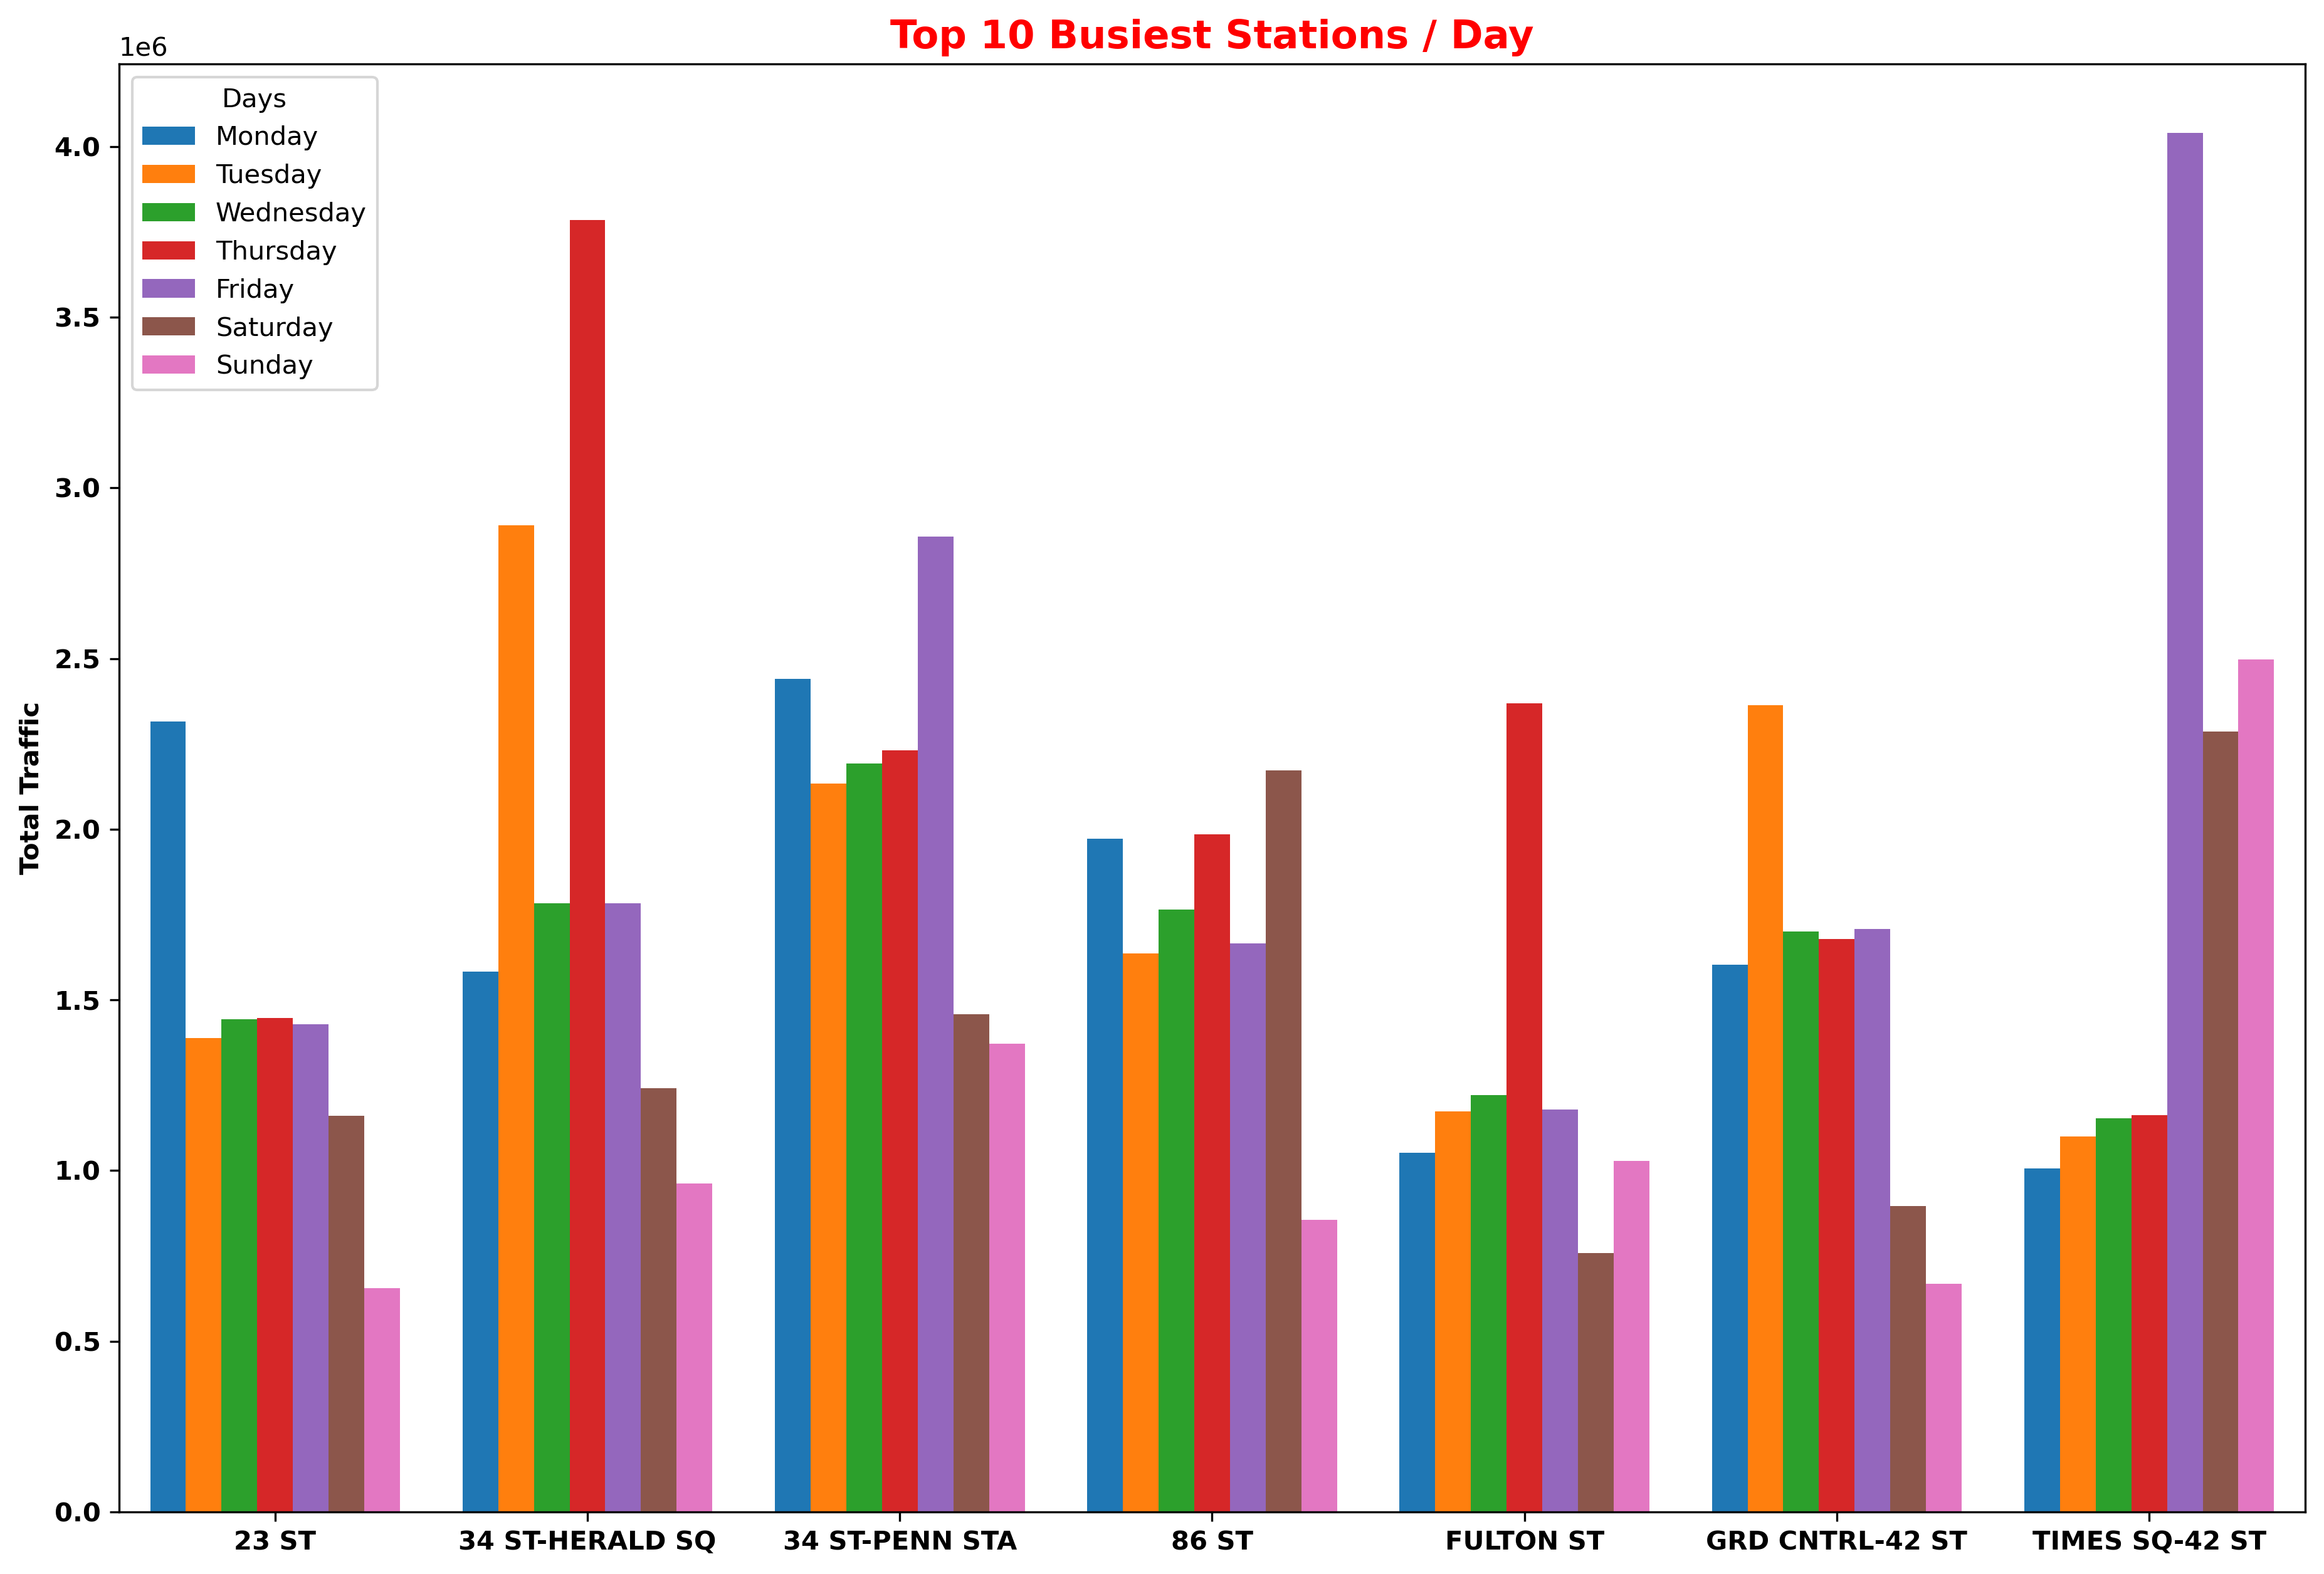

In [53]:
#Barplot for Top 10 Busiest Stations per Day

plt.figure(figsize=(15,10),dpi=300),
plt.style.use('default')
ax = sns.barplot(x="STATION", y="TRAFFIC", hue="NAMEOFDAY",data=mta_top10_daily_order, saturation=1)
plt.title("Top 10 Busiest Stations / Day", weight="bold", c="red", fontsize=15)
plt.xlabel("",weight="bold",c="k")
plt.xticks(rotation=0, weight="bold")
plt.ylabel("Total Traffic",weight= "bold",c="k")
plt.yticks(weight="bold")
plt.legend(title="Days")
plt.savefig('images/03_Top10BusiestStationsPerDayBarPlot.png', dpi=200)
plt.show()

# MTA Equipment EDA

In [60]:
equipment_data= pd.read_sql('SELECT * FROM elevator;', engine)
equipment_data

,station_name,equipment_id,description,borough,subway_lines,equipment_type,ada_compliant,is_active,direction,subset_lines,connection_to_street
0,Harlem-125 St,EL125,125 St & Lexington Ave (NE corner) to mezzanin...,MN,4/5/6,EL,Y,Y,both directions,4/5/6,Y
1,125 St (IRT Third Avenue Line),EL142,125 St & St Nicholas Ave (SW corner) to mezzan...,MN,A/B/C/D,EL,Y,Y,both directions,A/B/C/D,Y
2,125 St (IRT Third Avenue Line),EL143,mezzanine to downtown platform,MN,A/B/C/D,EL,Y,Y,downtown,A/B/C/D,N
3,Harlem-125 St,EL126,mezzanine to platforms for service in both dir...,MN,4/5/6,EL,Y,Y,both directions,4/5/6,N
4,125 St (IRT Third Avenue Line),EL144,mezzanine to uptown platform,MN,A/B/C/D,EL,Y,Y,uptown,A/B/C/D,N
...,...,...,...,...,...,...,...,...,...,...,...
608,WTC Cortlandt St,ES353,,MN,1,ES,N,Y,,1,N
609,WTC Cortlandt St,EL13X,Oculus main level to PATH level with access t...,MN,1/E/R/W,EL,Y,Y,both directions,1/E/R/W,N
610,WTC Cortlandt St,EL736,Greenwich Street (near southwest corner of Gre...,MN,1,EL,Y,N,downtown,"['1', '1']",N
611,WTC Cortlandt St,EL12X,West Concourse balcony to PATH level with acce...,MN,1/E/R/W,EL,Y,Y,both directions,1/E/R/W,N


In [61]:
equipment_data.columns = equipment_data.columns.str.strip()
equipment_data.columns

Index(['station_name', 'equipment_id', 'description', 'borough',
       'subway_lines', 'equipment_type', 'ada_compliant', 'is_active',
       'direction', 'subset_lines', 'connection_to_street'],
      dtype='object')

### Equipment Data Cleaning

replace spaces with 'null' because of reading from database problem

In [62]:
import numpy as np
equipment_data=equipment_data.replace([''],[np.nan])
equipment_data=equipment_data.replace([' '],[np.nan])

Check for null values

In [63]:
equipment_data.isnull().sum()

station_name              0
equipment_id              0
description              32
borough                   0
subway_lines             14
equipment_type            0
ada_compliant             0
is_active                 0
direction               406
subset_lines             14
connection_to_street      0
dtype: int64

In [64]:
# % of missing.
for col in equipment_data.columns:
    pct_missing = np.mean(equipment_data[col].isna())
    print('{} - {}%'.format(col, round(pct_missing*100)))

station_name - 0%
equipment_id - 0%
description - 5%
borough - 0%
subway_lines - 2%
equipment_type - 0%
ada_compliant - 0%
is_active - 0%
direction - 66%
subset_lines - 2%
connection_to_street - 0%


**Deal with null values**

In [65]:
#drop the direction columns
equipment_data.drop(columns='direction', inplace=True)

In [66]:
#check if the subway_lines and subset_lines are identical
equipment_data['subway_lines'].equals(equipment_data['subset_lines'])

False

In [67]:
equipment_data['subway_lines'] = equipment_data['subway_lines'].fillna(value='Not Specified')
equipment_data['subset_lines'] = equipment_data['subset_lines'].fillna(value='Not Specified')

In [68]:
equipment_data['description'] = equipment_data['description'].fillna(value='No description')

Change the **notation of 'station_name' column** to match the station column in MTA turnstile data

In [69]:
equipment_data['station_name']= equipment_data['station_name'].str.upper()

In [70]:
equipment_data['station_name']= equipment_data['station_name'].apply(lambda x: x.replace(' - ','-'))

In [111]:
x1= pd.DataFrame(data= equipment_data["station_name"].unique(), columns=['station'])
x2= pd.DataFrame(data= turnstile_data["STATION"].unique(),columns=['station'])
x1['MATCH']= ""
x2['MATCH']= ""
for val in x2['station']:
    syntax = val [0:6]
    try:
        n= (x1.index[x1['station'].str[0:6] == syntax].tolist())[0]
        x1.at[n,'MATCH']= val
    except IndexError:
        n= (x2.index[x2['station'] == val].tolist())[0]
        x2.at[n,'MATCH']= "NO MATCH"
    
    

In [387]:
x1.at[70,'MATCH']='NO MATCH'
x1.at[101,'MATCH']='NO MATCH'

In [73]:
#check x1 dataframe which containts matching pairs of station name from two data sets 
x1.sample(5)

,station,MATCH
109,PELHAM PKWY,PELHAM PKWY
9,168 ST,168 ST
24,34 ST-PENN,34 ST-PENN STA
97,KEW GARDENS / UNION TPK,KEW GARDENS
36,61 ST-WOODSIDE,61 ST WOODSIDE


In [330]:
#save it into csv file
x1.to_csv('equipment_stations.csv', index=False)

In [74]:
equipment_data=pd.merge(equipment_data, x1, left_on='station_name', right_on='station')

In [76]:
equipment_data.tail(20)

,station_name,equipment_id,description,borough,subway_lines,equipment_type,ada_compliant,is_active,subset_lines,connection_to_street
593,W 4 ST-WASH SQ,EL334,downtown A/C/E platform to transfer mezzanine ...,MN,A/B/C/D/E/F/M,EL,Y,Y,A/B/C/D/E/F/M,N
594,W 4 ST-WASH SQ,ES325,It operates between lower platform for B/D/F/M...,MN,A/B/C/D/E/F/M,ES,N,Y,A/B/C/D/E/F/M,N
595,W 4 ST-WASH SQ,ES326,It operates between lower platform for B/D/F/M...,MN,A/B/C/D/E/F/M,ES,N,Y,A/B/C/D/E/F/M,N
596,W 4 ST-WASH SQ,EL335,uptown A/C/E platform to transfer mezzanine an...,MN,A/B/C/D/E/F/M,EL,Y,Y,A/B/C/D/E/F/M,N
597,W 4 ST-WASH SQ,EL333,W 3rd St & 6th Ave (NE corner) to mezzanine fo...,MN,A/B/C/D/E/F/M,EL,Y,Y,A/B/C/D/E/F/M,N
598,W 8 ST-AQUARIUM,ES335,It operates between mezzanine and upper platfo...,BKN,F/Q,ES,N,Y,F/Q,N
599,WEST FARMS SQ,ES106,It operates between street at East 178 St & Bo...,BX,5-Feb,ES,N,Y,5-Feb,N
600,WHITEHALL S-FRY,ES351,It operates between lower mezzanine above R/W ...,MN,R/W,ES,N,Y,['R/W'],N
601,WHITEHALL S-FRY,ES312,It operates between lower mezzanine above R/W ...,MN,R/W,ES,N,Y,['R/W'],N
602,WHITEHALL S-FRY,ES311,It operates between lower mezzanine above R/W ...,MN,R/W,ES,N,Y,['R/W'],N


In [391]:
equipment_data['station_name'] = equipment_data['MATCH']

In [392]:
equipment_data.drop(columns='MATCH', inplace=True)

In [393]:
equipment_data.drop(columns='station', inplace=True)

In [394]:
equipment_data.head(30)

,station_name,equipment_id,description,borough,subway_lines,equipment_type,ada_compliant,is_active,subset_lines,connection_to_street
0,HARLEM 148 ST,EL125,125 St & Lexington Ave (NE corner) to mezzanin...,MN,4/5/6,EL,Y,Y,4/5/6,Y
1,HARLEM 148 ST,EL126,mezzanine to platforms for service in both dir...,MN,4/5/6,EL,Y,Y,4/5/6,N
2,125 ST,EL142,125 St & St Nicholas Ave (SW corner) to mezzan...,MN,A/B/C/D,EL,Y,Y,A/B/C/D,Y
3,125 ST,EL143,mezzanine to downtown platform,MN,A/B/C/D,EL,Y,Y,A/B/C/D,N
4,125 ST,EL144,mezzanine to uptown platform,MN,A/B/C/D,EL,Y,Y,A/B/C/D,N
5,125 ST,ES102,It operates between street near SW corner of 1...,MN,1,ES,N,Y,['1'],N
6,125 ST,ES101,It operates between street near SW corner of 1...,MN,1,ES,N,Y,['1'],N
7,125 ST,ES103,It operates between street near SE corner of 1...,MN,1,ES,N,Y,['1'],N
8,135 ST,EL180,135 St & Lenox Ave (NE corner) to uptown and t...,MN,2/3,EL,Y,Y,2/3,Y
9,135 ST,EL181,135 St & Lenox Ave (SW corner) to downtown pla...,MN,2/3,EL,Y,Y,2/3,Y


save to .csv file after cleaning

In [406]:
equipment_data.to_csv('E_list.csv', index=True)

In [133]:
equipment_data.sample(5)

,station_name,equipment_id,description,borough,subway_lines,equipment_type,ada_compliant,is_active,subset_lines,connection_to_street
573,SUTPHIN-ARCHER,EL449X,Sutphin Blvd & Archer Ave (SW intersection) to...,QNS,E/J/Z/LIRR,EL,Y,Y,E/J/Z/LIRR,N
462,JUNCTION BLVD,EL427,overpass to Flushing Main St-bound platform,QNS,7,EL,Y,Y,7,N
119,34 ST-PENN STA,EL215,concourse level of Penn Station to platform fo...,MN,1/2/3/LIRR,EL,Y,Y,1/2/3/LIRR,N
121,34 ST-PENN STA,EL214,concourse level of Penn Station to platform fo...,MN,1/2/3/LIRR,EL,Y,Y,1/2/3/LIRR,N
348,DELANCEY/ESSEX,ES328,It operates between platform of northbound F L...,MN,F/J/M/Z,ES,N,Y,F/J/M/Z,N


**Find list of equipments for each station**

In [77]:
len(equipment_data["station_name"].unique())

125

In [78]:
equipments_in_station = equipment_data.groupby('station_name')['equipment_id'].apply(list).reset_index()
equipments_in_station

,station_name,equipment_id
0,125 ST,"[EL142, EL143, EL144, ES102, ES101, ES103]"
1,135 ST,"[EL180, EL181]"
2,14 ST,"[EL221, EL222, EL223]"
3,14 ST-UNION SQ,"[EL217, EL220, EL218, EL219, ES257X, ES258X, E..."
4,145 ST,"[ES116, ES115]"
...,...,...
120,WALL ST,"[ES379X, ES378X]"
121,WEST FARMS SQ,[ES106]
122,WHITEHALL S-FRY,"[ES351, ES312, ES311]"
123,WORLD TRADE CTR,"[EL326, EL23X]"


# Data Analysis

To explore data, obtain the number of devices (turstiles, elevators, escalators) at each one of the top 10 stations

In [79]:
station_devices = pd.DataFrame(data =top_10_stations['STATION'])

In [80]:
def count_device(colmn,x):
    ls=[]
    for station in station_devices['STATION']:
        df= equipment_data[equipment_data['station_name']== station]
        try:
            c= df[df["equipment_type"]== x].groupby("equipment_type")['equipment_id'].count().values[0]
            
        except IndexError:
            c=0
        ls.append(c)
    station_devices[colmn]= ls

count the elevators and escalators

In [81]:
#initial values
station_devices["#ESCALATORS"] = 0
station_devices["#ELEVATORS"] = 0
station_devices["#TURNSTILES"] = 0
station_devices

,STATION,#ESCALATORS,#ELEVATORS,#TURNSTILES
0,34 ST-PENN STA,0,0,0
1,34 ST-HERALD SQ,0,0,0
2,TIMES SQ-42 ST,0,0,0
3,86 ST,0,0,0
4,125 ST,0,0,0
5,PATH NEW WTC,0,0,0
6,GRD CNTRL-42 ST,0,0,0
7,23 ST,0,0,0
8,42 ST-PORT AUTH,0,0,0
9,14 ST-UNION SQ,0,0,0


count the elevators and escalators

In [82]:
count_device("#ESCALATORS","ES")

In [83]:
count_device("#ELEVATORS","EL")

count turnstiles

In [84]:
ls=[]
for station in station_devices['STATION']:
    try:
        df= turnstile_data[turnstile_data['STATION']== station]
        c= len(df['turnstile'].value_counts())
    except IndexError:
        c=0
    ls.append(c)
ls

[111, 55, 42, 65, 43, 45, 89, 88, 51, 41]

In [85]:
station_devices['#TURNSTILES']= ls

In [86]:
station_devices.head(10)

,STATION,#ESCALATORS,#ELEVATORS,#TURNSTILES
0,34 ST-PENN STA,0,8,111
1,34 ST-HERALD SQ,12,6,55
2,TIMES SQ-42 ST,7,5,42
3,86 ST,0,4,65
4,125 ST,3,3,43
5,PATH NEW WTC,0,0,45
6,GRD CNTRL-42 ST,13,5,89
7,23 ST,0,2,88
8,42 ST-PORT AUTH,2,4,51
9,14 ST-UNION SQ,3,4,41


Plot

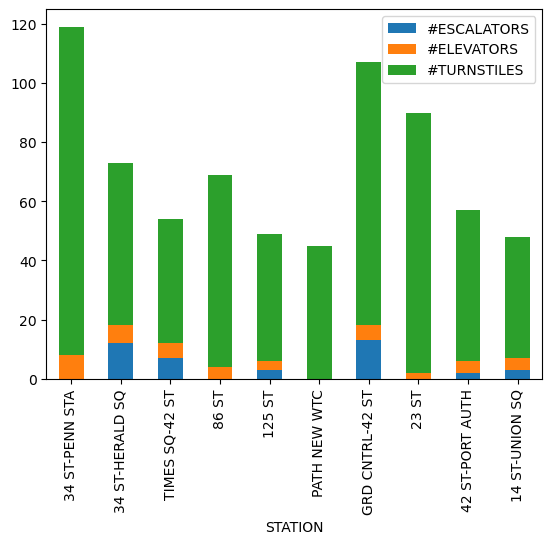

In [87]:
station_devices.plot.bar(x="STATION",stacked=True)
plt.show()

## Equipment outage dataset

analyzing the obtained equipment outages dataset from **MTA API** which has the **current** devices outages. meaning: equipment that hasn't been fixed yet.

In [88]:
current_outages = pd.read_csv("e_outages.csv")

In [89]:
current_outages

,station,borough,trainno,equipment,equipmenttype,serving,ADA,outagedate,estimatedreturntoservice,reason,isupcomingoutage,ismaintenanceoutage
0,125 St,MN,A/B/C/D,EL143,EL,Mezzanine to downtown Platform,Y,10/07/2021 10:35:00 PM,10/08/2021 5:00:00 AM,Maintenance,Y,N
1,125 St,MN,1,ES103,ES,Street to Mezzanine,N,09/29/2021 11:02:00 AM,10/01/2021 11:00:00 PM,Repair,N,N
2,125 St,MN,1,ES103,ES,Street to Mezzanine,N,10/28/2021 8:00:00 AM,05/31/2022 12:00:00 AM,Capital Replacement,Y,N
3,14 St - Union Sq,MN,L/N/Q/R/W,ES257X,ES,Street to Mezzanine all trains,N,09/27/2021 8:10:00 PM,09/29/2021 8:00:00 PM,Repair,N,N
4,145 St,MN,A/B/C/D,ES116,ES,Northbound ll Platform to Upper Mezzanine,N,09/29/2021 3:30:00 PM,09/30/2021 12:00:00 AM,Under Investigation,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...
63,South Ferry,MN,1,ES375,ES,Mezzanine to Street,N,09/28/2021 5:46:00 AM,09/30/2021 11:00:00 PM,Repair,N,N
64,Sutphin Blvd - Archer Av - JFK Airport,QNS,E/J/Z/LIRR,ES432X,ES,Street to Mezzanine to E/J/Z,N,09/26/2021 11:00:00 AM,09/30/2021 11:00:00 AM,Repair,N,N
65,Sutphin Blvd - Archer Av - JFK Airport,QNS,E/J/Z/LIRR,EL448X,EL,Sutphin Blvd &amp; Archer Ave (SW intersection...,Y,09/26/2021 10:57:00 AM,09/30/2021 11:00:00 AM,Repair,N,N
66,West 4 St - Washington Sq,MN,A/B/C/D/E/F/M,EL333,EL,W 3rd St &amp; 6th Ave (NE corner) to turnstil...,Y,09/29/2021 1:41:00 PM,09/29/2021 10:00:00 PM,Under Investigation,N,N


Find the most common reason for outage

In [90]:
reasons = (current_outages.groupby('reason', as_index=False).agg({'outagedate': 'count'}).rename(columns={'outagedate': 'count'}))
reasons

,reason,count
0,Capital Replacement,18
1,Elevator Rehabilitation,1
2,Entrance Closed,1
3,Inspection,1
4,Maintenance,3
5,Planned Work,2
6,Repair,22
7,Station Is Under Rehabilitation,1
8,Under Investigation,18
9,Warranty Repair,1


plot the result

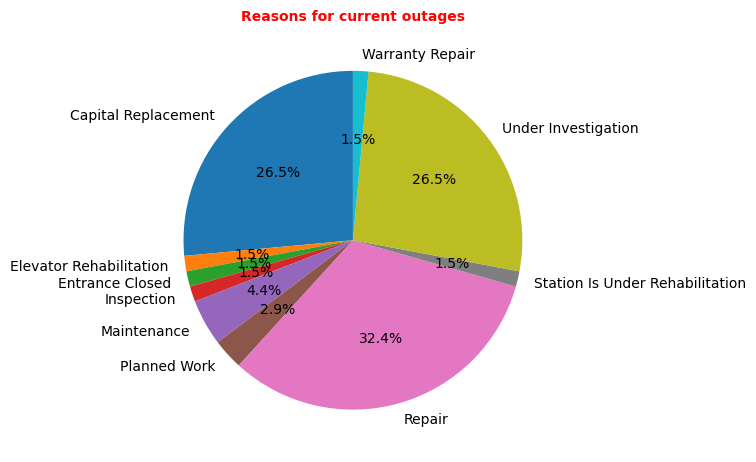

In [91]:
plt.style.use('seaborn-notebook')
fig1, ax1 = plt.subplots()
reasons_list = list(reasons["reason"])
values = list(reasons["count"])
ax1.pie(values, labels=reasons_list, autopct='%1.1f%%', startangle=90)
plt.title("Reasons for current outages", weight="bold", c="red", fontsize=10)
plt.savefig('images/commonreasonsPieChart.png', dpi=200)
plt.show()

Rank the importance of equipments located at the top 10 busiest station

In [92]:
list_of_top_stations = list(top_10_stations['STATION'])
list_of_top_stations

['34 ST-PENN STA',
 '34 ST-HERALD SQ',
 'TIMES SQ-42 ST',
 '86 ST',
 '125 ST',
 'PATH NEW WTC',
 'GRD CNTRL-42 ST',
 '23 ST',
 '42 ST-PORT AUTH',
 '14 ST-UNION SQ']

In [111]:
rank = list(range(11, 1, -1))

In [105]:
equipments_in_station.head()

,station_name,equipment_id,Importance
0,125 ST,"[EL142, EL143, EL144, ES102, ES101, ES103]",7
1,135 ST,"[EL180, EL181]",0
2,14 ST,"[EL221, EL222, EL223]",0
3,14 ST-UNION SQ,"[EL217, EL220, EL218, EL219, ES257X, ES258X, E...",0
4,145 ST,"[ES116, ES115]",0


In [97]:
equipments_in_station["Importance"]=1

In [117]:
for station in equipments_in_station['station_name']:
    inx =equipments_in_station.index[equipments_in_station['station_name']==station].tolist()
    if station in list_of_top_stations:
        ind= list_of_top_stations.index(station)
        equipments_in_station.at[inx[0],"Importance"] =rank[ind]
    else:
        equipments_in_station.at[inx[0],"Importance"] =1

In [118]:
equipments_in_station.tail(20)

,station_name,equipment_id,Importance
105,PARKCHESTER,[ES111],1
106,PELHAM BAY PARK,"[EL121, ES121, EL122, ES120]",1
107,PELHAM PKWY,"[EL137, EL138, ES123, ES122, EL136]",1
108,PRESIDENT ST,[ES304],1
109,PROSPECT AV,"[EL383, EL382]",1
110,QUEENS PLAZA,"[EL430, EL429, EL428]",1
111,ROOSEVELT ISLND,"[ES413, ES412, ES411, ES415, ES414, ES416, ES4...",1
112,SIMPSON ST,"[EL128, EL127]",1
113,SMITH-9 ST,"[ES315, ES349, ES316, ES348, ES314, ES313]",1
114,SOUTH FERRY,"[EL731, ES373, ES369, ES370, ES375, ES372, ES3...",1


The maintainence department can priritiza equipments with rank = 11

# Conclusion 

 - Schedule the maintenance work at : Friday, Sunday
 - Prioritize maintenance work for devices located at busy stations. 
 - Replace the frequently outage elevators and escalators
